# **3. XGBoost Model**

## Imports

In [194]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [195]:
df = pd.read_csv('data/data_model.csv')

In [196]:
df.head()

,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,...,False,False,False,False,False,False,False,False,False,False
1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,...,False,False,False,False,False,False,False,False,False,False
2,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,...,False,False,False,False,False,False,False,False,False,False
3,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,...,False,False,False,False,False,False,False,False,False,False
4,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,...,False,False,False,False,False,False,False,False,False,False


In [197]:
# Split date up into year, month, week, day for more
df['Day'] = pd.to_datetime(df['Date']).dt.day
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Week'] = pd.to_datetime(df['Date']).dt.isocalendar().week

In [198]:
df.set_index('Date', inplace=True)

In [199]:
df.head()

,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,...,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Day,Year,Month,Week
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,...,False,False,False,False,False,False,5,2010,2,5
2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,...,False,False,False,False,False,False,5,2010,2,5
2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,...,False,False,False,False,False,False,5,2010,2,5
2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,...,False,False,False,False,False,False,5,2010,2,5
2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,...,False,False,False,False,False,False,5,2010,2,5


In [200]:
# Helper function for evalution metrics
def evaluation_metrics(y_test,y_pred):
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test,y_pred)
    r2score = r2_score(y_test,y_pred)
    
    print(f'Mean Squared Error = {mse}')
    print(f'Mean Absolute Error = {mae}')
    print(f'Root Mean Squared Error = {rmse}')
    print(f'r2 score = {r2score}')

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

### Train Test Split

In [201]:
X = df.drop(columns='Weekly_Sales')
y = df[['Weekly_Sales']]

In [202]:
# scale = MinMaxScaler()
# X = pd.DataFrame(scale.fit_transform(X),columns=X.columns)
# X.head()

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((337256, 141), (84314, 141), (337256, 1), (84314, 1))

In [204]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

# params={ 'objective':'reg:squarederror',
#          'max_depth': 6, 
#          'colsample_bylevel':0.5,
#          'learning_rate':0.01,
#          'random_state':20}

In [205]:
# xgb_model = XGBRegressor(random_state=123, n_jobs=4, n_estimators=20, max_depth=4)
xgb_model = XGBRegressor(random_state=123)

In [206]:
xgb_rs = RandomizedSearchCV(estimator=xgb_model,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=20,
                         n_jobs=8,
                         verbose=1)

# RandomizedSearchCV(, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')

In [207]:
# xgb_model.fit(X_train, y_train)
xgb_rs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          num_parallel_tree=None,
                                          random_state=123, ...),
                   n_iter=20, n_jobs=8,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 6, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='neg_mean_squared_error', verbose=1)

In [208]:
# Print the best set of hyperparameters and the corresponding score
# print("Best set of hyperparameters: ", xgb_rs.best_params_)
# print("Lowest RMSE: ", xgb_rs.best_score_)

In [209]:
xgb_model.fit(X_train, y_train)
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

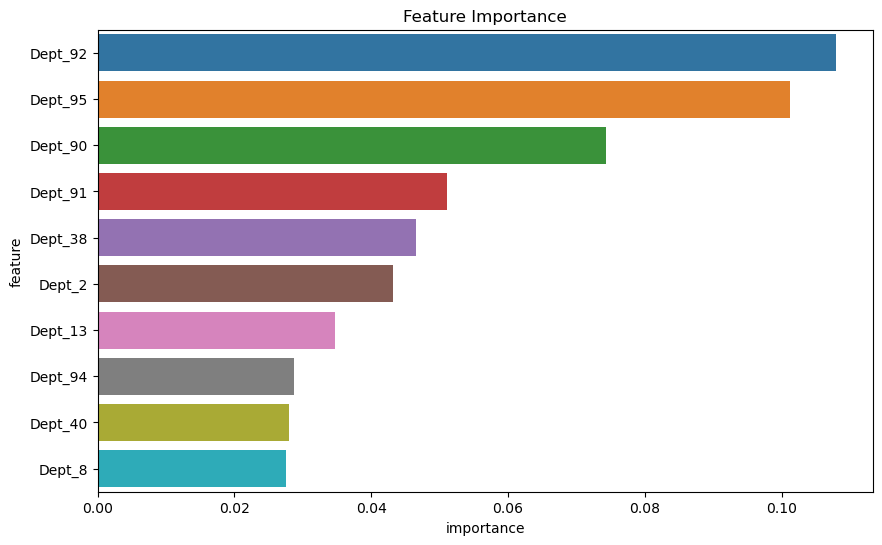

In [210]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [211]:
# Make and evaluate predictions:
# xgb_preds = xgb_model.predict(X_test)
xgb_preds = xgb_rs.predict(X_test)
xgb_preds

array([ 10859.273 ,  11559.776 , 169543.27  , ...,  41380.566 ,
         4626.953 ,    679.7992], dtype=float32)

In [212]:
rmse(xgb_preds, y_test)

8189.199231713278

In [213]:
Comparison = X_test.copy("deep")
Comparison['Actual Sales ($M)'] = y_test['Weekly_Sales']
Comparison['Predicted Sales ($M)'] = xgb_preds
Comparison.head()

,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,...,Dept_96,Dept_97,Dept_98,Dept_99,Day,Year,Month,Week,Actual Sales ($M),Predicted Sales ($M)
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-16,40.68,3.413,5115.93,0.27,10748.31,601.89,14608.23,140.470079,8.745,False,...,False,False,False,False,16,2011,12,50,8829.91,10859.273438
2011-12-16,40.68,3.413,5115.93,0.27,10748.31,601.89,14608.23,140.470079,8.745,False,...,False,False,False,False,16,2011,12,50,11664.36,11559.776367
2011-12-16,40.68,3.413,5115.93,0.27,10748.31,601.89,14608.23,140.470079,8.745,False,...,False,False,False,False,16,2011,12,50,113554.86,169543.265625
2011-12-16,40.68,3.413,5115.93,0.27,10748.31,601.89,14608.23,140.470079,8.745,False,...,False,False,False,False,16,2011,12,50,18029.02,20298.007812
2011-12-16,40.68,3.413,5115.93,0.27,10748.31,601.89,14608.23,140.470079,8.745,False,...,False,False,False,False,16,2011,12,50,204.00,534.142883


In [214]:
Comparison1 = Comparison.groupby('Date')[['Actual Sales ($M)', 'Predicted Sales ($M)']].sum().round(1)/1000000

In [246]:
Comparison1.reset_index(inplace=True)
Comparison1['Date'] = pd.to_datetime(Comparison1['Date'])

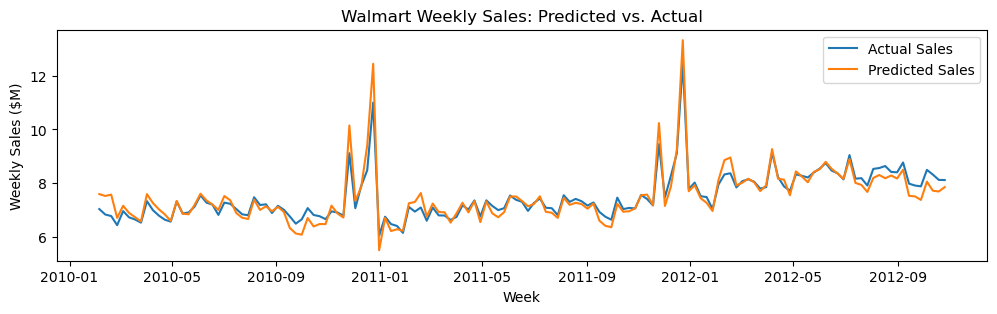

In [263]:
plt.figure(figsize = (12,3))
# sns.lineplot(Comparison1, x = 'Date', y = 'Actual Sales ($M)')
# sns.lineplot(Comparison1, x = 'Date', y = 'Predicted Sales ($M)')
plt.plot(Comparison1['Date'], Comparison1['Actual Sales ($M)'])
plt.plot(Comparison1['Date'], Comparison1['Predicted Sales ($M)'])
# plt.plot(Comparison1, x = 'Date', y = 'Predicted Sales ($M)')
# plt.ylim(40, 55)
# plt.ticklabel_format(useOffset=False,style='plain',axis='y')
plt.xlabel('Week')
plt.ylabel('Weekly Sales ($M)')
plt.title('Walmart Weekly Sales: Predicted vs. Actual')
plt.legend(['Actual Sales','Predicted Sales'])
plt.show()

In [217]:
# xgb_scores = cross_val_score(xgb_model, X_train, y_train)
# xgb_scores = cross_val_score(xgb_rs, X_train, y_train)
# np.mean(xgb_scores)

In [218]:
evaluation_metrics(y_test, xgb_preds)

Mean Squared Error = 67062984.056693345
Mean Absolute Error = 4708.290646212617
Root Mean Squared Error = 8189.199231713278
r2 score = 0.8064340743831665


### Test Data

In [219]:
data_test = pd.read_csv('data/data_test.csv')

In [220]:
# Split date up into year, month, week, day for more
data_test['Day'] = pd.to_datetime(data_test['Date']).dt.day
data_test['Year'] = pd.to_datetime(data_test['Date']).dt.year
data_test['Month'] = pd.to_datetime(data_test['Date']).dt.month
data_test['Week'] = pd.to_datetime(data_test['Date']).dt.isocalendar().week

In [221]:
data_test.set_index('Date', inplace=True)

In [222]:
data_test.head()

,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,...,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Day,Year,Month,Week
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,...,False,False,False,False,False,False,2,2012,11,44
2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,...,False,False,False,False,False,False,2,2012,11,44
2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,...,False,False,False,False,False,False,2,2012,11,44
2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,...,False,False,False,False,False,False,2,2012,11,44
2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,...,False,False,False,False,False,False,2,2012,11,44


In [223]:
data_test.shape

(115064, 141)

In [224]:
data_test.isna().sum().sort_values(ascending=False)

CPI             38162
Unemployment    38162
Temperature         0
Dept_43             0
Dept_37             0
                ...  
Store_31            0
Store_30            0
Store_29            0
Store_28            0
Week                0
Length: 141, dtype: int64

In [225]:
data_test = data_test.fillna(data_test.mean())

In [226]:
data_test.isna().sum().sort_values(ascending=False)

Temperature    0
Dept_43        0
Dept_37        0
Dept_38        0
Dept_39        0
              ..
Store_30       0
Store_29       0
Store_28       0
Store_27       0
Week           0
Length: 141, dtype: int64

In [227]:
test_preds = xgb_rs.predict(data_test)

In [228]:
data_test['pred'] = test_preds

C:\Users\johng\AppData\Local\Temp\ipykernel_26168\464179709.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_test['pred'] = test_preds


In [229]:
data_test

,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,...,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Day,Year,Month,Week,pred
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,False,...,False,False,False,False,False,2,2012,11,44,17131.650391
2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,False,...,False,False,False,False,False,2,2012,11,44,46885.292969
2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,False,...,False,False,False,False,False,2,2012,11,44,10344.523438
2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,False,...,False,False,False,False,False,2,2012,11,44,33477.648438
2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,False,...,False,False,False,False,False,2,2012,11,44,22778.072266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,176.961347,6.868733,False,...,False,False,False,False,False,26,2013,7,30,2846.771484
2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,176.961347,6.868733,False,...,False,False,False,False,False,26,2013,7,30,3219.182129
2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,176.961347,6.868733,False,...,True,False,False,False,False,26,2013,7,30,51171.890625


In [230]:
submission1 = pd.read_csv('data/sampleSubmission.csv')

In [231]:
submission1['Weekly_Sales'] = test_preds

In [232]:
submission1.set_index('Id', inplace=True)

In [233]:
submission1.to_csv('data/submission_xgb1.csv')

In [234]:
# Sources
# https://www.kaggle.com/code/akritiupadhyayks/walmart-sales-forecasting-by-prophet-and-xgboost